In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import datetime as dt
from dateutil.relativedelta import relativedelta

def parse_dt(date_string):

    date = dt.datetime.strptime(date_string, r'%m-%d %H:%M')
    date = date + relativedelta(year = 2025)

    return date

decay_times_path = './data/decay_times.txt'
data_path = './data/october_RAW.csv'

## parsing timestamps
timestamps = open(decay_times_path).read().split('\n')
timestamps = [i.split(', ') for i in timestamps]
timestamps = [[parse_dt(date) for date in timestamp] for timestamp in timestamps]

## reading data
data = pd.read_csv(data_path, parse_dates=['UTC Date/Time'])
data['UTC Date/Time'] = data['UTC Date/Time'].dt.tz_localize(None)
data['UTC Date/Time'] = data['UTC Date/Time'].dt.round(freq='min')
focus_data = data[['UTC Date/Time', 'CO2 (ppm) raw']]

decay_data = [
    focus_data[(focus_data['UTC Date/Time'] > ts[0]) & (focus_data['UTC Date/Time'] < ts[1])] for ts in timestamps
]

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for decay in decay_data:
    decay.plot(y = 'CO2 (ppm) raw', x = 'UTC Date/Time', ax=ax)

In [ ]:
decay_reversed = decay.reindex(index=decay.index[::-1]).reset_index()
x = decay_reversed.index
scale = decay_reversed['CO2 (ppm) raw'].max() - decay_reversed['CO2 (ppm) raw'].min()
tr = decay_reversed['CO2 (ppm) raw'].min()
decay_reversed.plot(y = 'CO2 (ppm) raw', use_index = True)
plt.plot(x, scale*np.exp(-(x/50)) + tr, label='estimated curve')
plt.legend()

In [ ]:
from sklearn.linear_model import LinearRegression   

n_graphs = 3
fig, ax = plt.subplots(1, n_graphs, figsize=(7*n_graphs, 6))

def fit_curve(decay_df):

    decay_reversed = decay_df.reindex(index=decay_df.index[::-1]).reset_index()
    decay_reversed = decay_reversed.iloc[:100]

    min_val = decay_reversed['CO2 (ppm) raw'].min()
    decay_reversed['altered'] = decay_reversed['CO2 (ppm) raw'] - min_val

    log_concentration = np.log(decay_reversed['altered'])

    decay_reversed['log CO2'] = log_concentration

    x = decay_reversed.index
    
    decay_reversed.plot(y = 'CO2 (ppm) raw', use_index = True, ax = ax[0])
    ax[0].set_xlim(left=0)
    ax[0].set_title('Decay Concentration')

    decay_reversed.plot(y = 'log CO2', use_index = True, ax = ax[1])
    ax[1].set_xlim(left=0)
    ax[1].set_title('log Decay Concentration')

    coeffs = np.polyfit(x, decay_reversed['log CO2'], deg=1)


    tau = 50
    scale = decay_reversed['CO2 (ppm) raw'].max() - decay_reversed['CO2 (ppm) raw'].min()
    tr = decay_reversed['CO2 (ppm) raw'].min()

    #plt.plot(x, scale*np.exp(-(x/tau)) + tr, label='estimated curve')
    plt.legend()

fit_curve(decay_data[5])

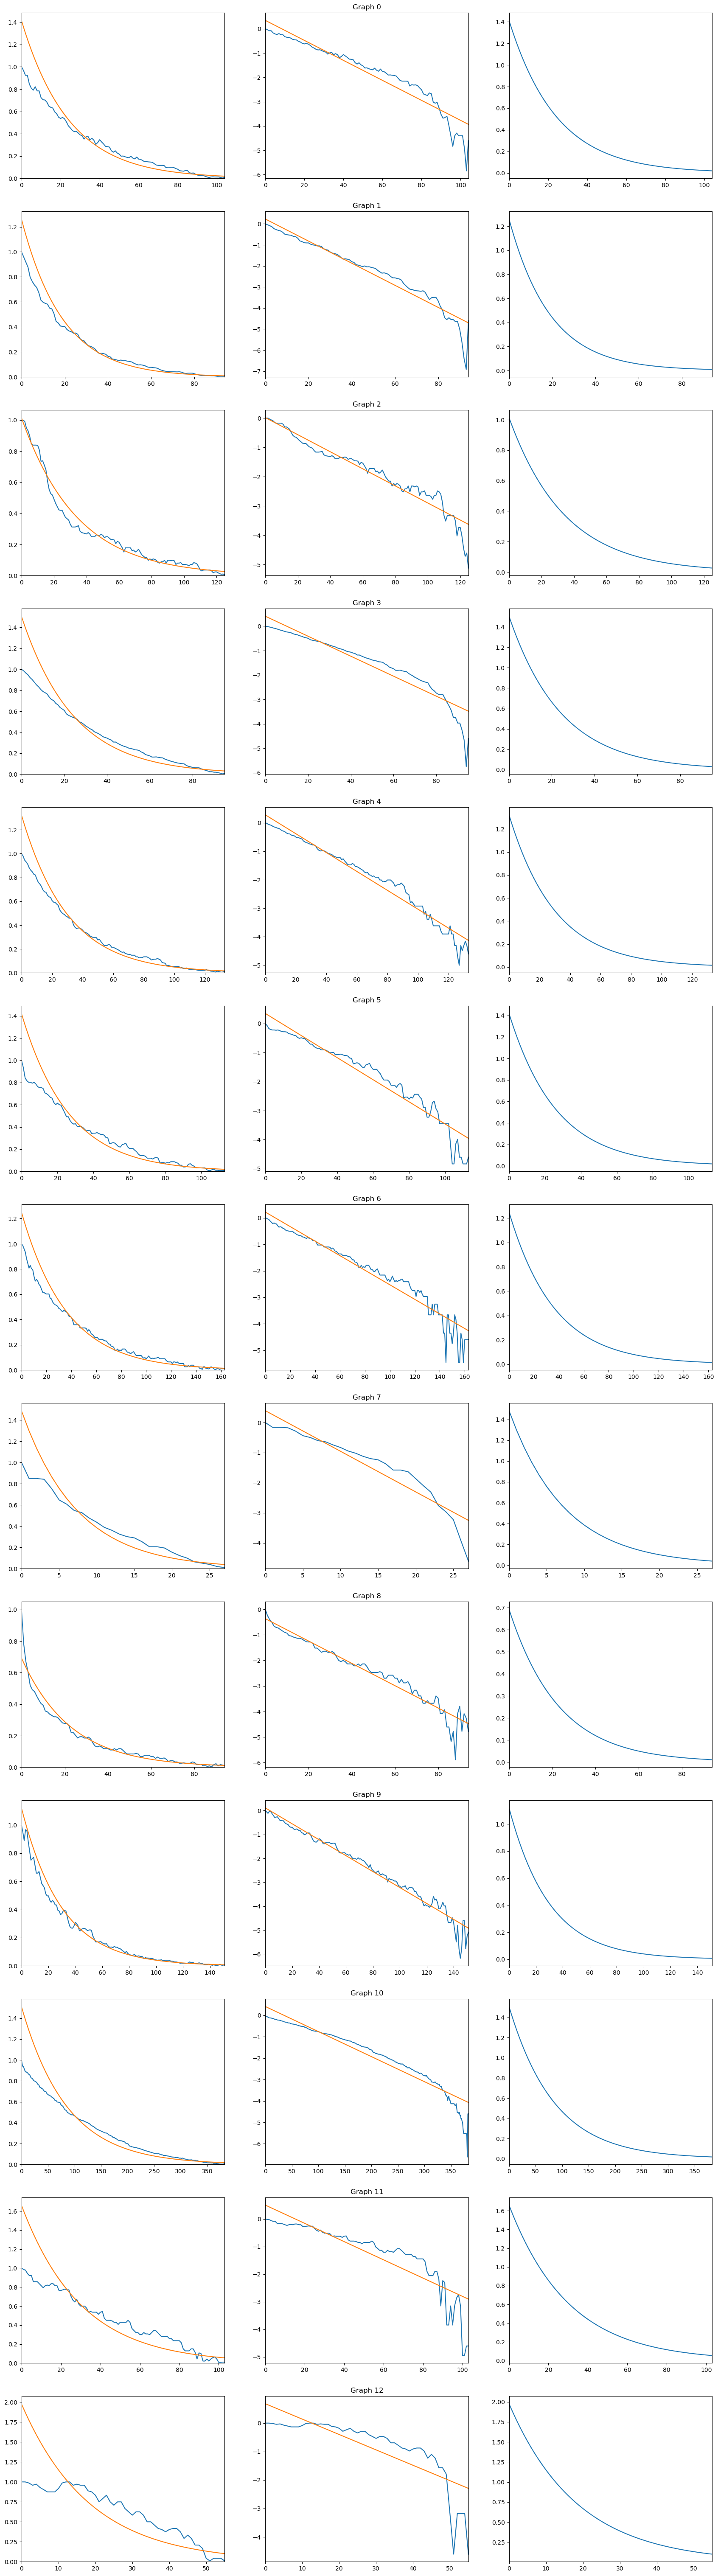

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

n_graphs = 3
n_rows = len(decay_data)
fig, axs = plt.subplots(n_rows, n_graphs, figsize=(7*n_graphs, 6*n_rows))

base = np.e
epsilon = 0.01

for idd, data in enumerate(decay_data):
    
    ax = axs[idd]
    decay_df = decay_data[idd].copy()

    scale = decay_df['CO2 (ppm) raw'].max() - decay_df['CO2 (ppm) raw'].min()
    decay_df['altered'] = decay_df['CO2 (ppm) raw'] / scale

    min_val = decay_df['altered'].min()
    decay_df['altered'] = decay_df['altered'] - min_val

    # decay_df[decay_df['altered']==0]['altered'] = decay_df[decay_df['altered']==0]['altered'] + epsilon ## avoid -inf values
    decay_df.loc[decay_df['altered'] <= 0, 'altered'] += epsilon

    decay_reversed = decay_df.reindex(index=decay_df.index[::-1]).reset_index()
    x = np.array(decay_reversed.index)

    log_concentration = np.log(decay_reversed['altered'])

    decay_reversed['log CO2'] = log_concentration

    model = LinearRegression()
    model.fit(x.reshape(-1, 1), decay_reversed['log CO2'])

    coeffs = np.polyfit(x, decay_reversed['log CO2'], deg=1)
    #predictions = coeffs[0]*x + coeffs[1]
    predictions = model.predict(x.reshape(-1, 1))
    full_pred = np.power(base, predictions)
    min_pred = min(predictions)

    ax[0].plot(x, decay_reversed['altered'])
    ax[0].plot(x, full_pred)
    ax[0].set_xlim(0, max(x))
    ax[0].set_ylim(0)

    ax[1].plot(x, decay_reversed['log CO2'])
    ax[1].plot(x, predictions)
    #ax[1].set_yscale('log', base=base)
    ax[1].set_xlim(0, max(x))
    #ax[1].set_ylim(0)

    ax[2].plot(x, full_pred)
    #ax[2].set_yscale('log', base=base)
    ax[2].set_xlim(0, max(x))
    #ax[2].set_ylim(0)

    ax[1].set_title(f'Graph {idd}')

In [ ]:
coeffs